In [ ]:
pip install pandas numpy xgboost scikit-learn deap matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 4.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv(r"/content/preprocessed_train_data.csv")
df.head()

,Timestamp,Residents,Apartment_Type,Temperature,Humidity,Water_Price,Period_Consumption_Index,Income_Level,Guests,Amenities,Appliance_Usage,Water_Consumption
0,2002-01-01 00:00:00,1.0,7,15.31,1476,1.06,0.97,193,0.000000,4,0.0,64.85
1,2002-01-01 08:00:00,4.0,6,21.01,3404,2.98,0.91,239,1.000000,4,1.0,192.50
2,2002-01-01 16:00:00,2.0,4,12.86,2901,1.44,1.43,196,0.000000,3,1.0,116.62
3,2002-01-02 00:00:00,2.0,0,20.16,1874,1.48,0.91,196,0.307359,1,0.0,76.96
4,2002-01-02 08:00:00,2.0,4,16.23,2040,1.14,1.11,196,0.000000,0,0.0,104.70


In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp').reset_index(drop=True)

In [ ]:
X = df.drop(['Timestamp', 'Water_Consumption'], axis=1)
y = df['Water_Consumption']

In [ ]:
# Time series split
tscv = TimeSeriesSplit(n_splits=5)
train_index, test_index = list(tscv.split(X))[-1]

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [ ]:
def evaluate(individual):
    rf_n_estimators = max(1, int(individual[0]))
    xgb_n_estimators = max(1, int(individual[1]))

    rf_model = RandomForestRegressor(n_estimators=rf_n_estimators, random_state=42)
    xgb_model = XGBRegressor(n_estimators=xgb_n_estimators, random_state=42)

    rf_model.fit(X_train, y_train)
    xgb_model.fit(X_train, y_train)

    stacked_X_train = np.column_stack((rf_model.predict(X_train), xgb_model.predict(X_train)))
    stacked_X_test = np.column_stack((rf_model.predict(X_test), xgb_model.predict(X_test)))

    meta_model = LinearRegression()
    meta_model.fit(stacked_X_train, y_train)

    final_preds = meta_model.predict(stacked_X_test)

    rmse = np.sqrt(mean_squared_error(y_test, final_preds))
    return rmse,

In [ ]:
POP_SIZE = 12
GEN_COUNT = 36

# Create DEAP classes
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 10, 500)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=10, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Run GA Optimization
population = toolbox.population(n=POP_SIZE)
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.3, ngen=GEN_COUNT,
                    stats=None, halloffame=None, verbose=True)

# Best individual
best_individual = tools.selBest(population, k=1)[0]
print(f"Best Hyperparameters: RF Estimators={max(1, int(best_individual[0]))}, XGB Estimators={max(1, int(best_individual[1]))}")



/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	12    
1  	11    
2  	6     
3  	8     
4  	2     
5  	4     
6  	7     
7  	11    
8  	8     
9  	10    
10 	8     
11 	8     
12 	10    
13 	10    
14 	9     
15 	9     
16 	8     
17 	9     
18 	8     
19 	9     
20 	8     
21 	10    
22 	10    
23 	9     
24 	6     
25 	10    
26 	12    
27 	8     
28 	10    
29 	7     
30 	6     
31 	9     
32 	8     
33 	4     
34 	7     
35 	7     
36 	7     
Best Hyperparameters: RF Estimators=182, XGB Estimators=269


In [9]:
rf_model = RandomForestRegressor(n_estimators=int(best_individual[0]), random_state=42)
xgb_model = XGBRegressor(n_estimators=int(best_individual[1]), random_state=42)

rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Stacking
stacked_X_train = np.column_stack((rf_model.predict(X_train), xgb_model.predict(X_train)))
stacked_X_test = np.column_stack((rf_model.predict(X_test), xgb_model.predict(X_test)))

meta_model = LinearRegression()
meta_model.fit(stacked_X_train, y_train)

# Final predictions
final_preds = meta_model.predict(stacked_X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, final_preds))
mae = mean_absolute_error(y_test, final_preds)

print(f"\n Final Model RMSE: {rmse:.2f}")
print(f"\n Final Model MAE: {mae:.2f}")

Final Model RMSE: 13.01
Final Model MAE: 7.86


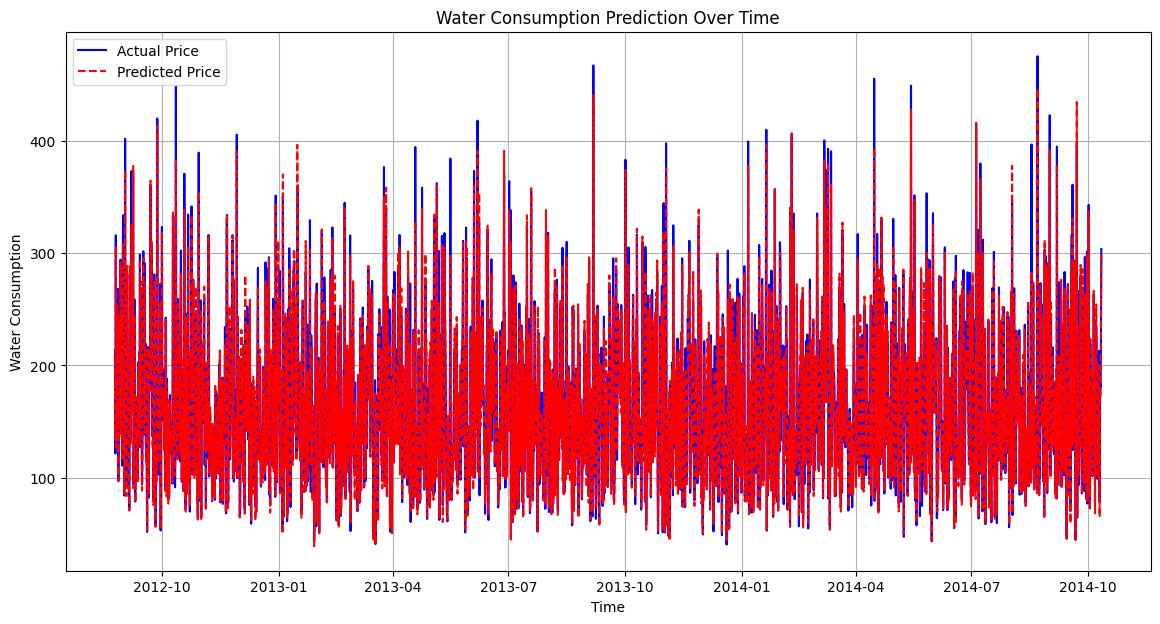

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(df['Timestamp'].iloc[test_index], y_test, label='Actual Price', color='blue')
plt.plot(df['Timestamp'].iloc[test_index], final_preds, label='Predicted Price', color='red', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Water Consumption')
plt.title('Water Consumption Prediction Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import joblib
# Save the models locally in Colab
joblib.dump(rf_model, '/content/rf_model.pkl')
joblib.dump(xgb_model, '/content/xgb_model.pkl')
joblib.dump(meta_model, '/content/meta_model.pkl')

print("Models saved successfully!")


Models saved successfully!


In [ ]:
from google.colab import files
# Download the models
files.download('/content/rf_model.pkl')
files.download('/content/xgb_model.pkl')
files.download('/content/meta_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_df=pd.read_csv(r"/content/preprocessed_test_data.csv")
test_df.head()

,Timestamp,Residents,Apartment_Type,Temperature,Humidity,Water_Price,Period_Consumption_Index,Income_Level,Guests,Amenities,Appliance_Usage
0,2014-10-11 16:00:00,5.0,3,11.89,1966,2.77,1.48,94,1.0,2,0.000000
1,2014-10-12 00:00:00,4.0,3,29.22,2274,2.85,1.30,94,0.0,1,0.198695
2,2014-10-12 08:00:00,3.0,4,10.27,2532,1.66,0.97,73,0.0,3,0.000000
3,2014-10-12 16:00:00,3.0,0,27.03,1508,1.48,1.31,70,0.0,3,0.000000
4,2014-10-13 00:00:00,2.0,4,12.32,1732,1.19,1.30,73,0.0,4,0.000000


In [ ]:
rf_model = joblib.load('/content/rf_model.pkl')
xgb_model = joblib.load('/content/xgb_model.pkl')
meta_model = joblib.load('/content/meta_model.pkl')

In [ ]:
test_df = test_df.sort_values('Timestamp').reset_index(drop=True)

In [ ]:
# Extract the features (excluding Timestamp)
X_test = test_df.drop(['Timestamp'], axis=1)

In [ ]:
# Make predictions with the base models
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)


In [ ]:
# Stacking predictions
stacked_X_test = np.column_stack((rf_preds, xgb_preds))
final_preds = meta_model.predict(stacked_X_test)

In [ ]:
dt_df=pd.read_csv(r"/content/test.csv")
dt_df.head()

,Timestamp,Residents,Apartment_Type,Temperature,Humidity,Water_Price,Period_Consumption_Index,Income_Level,Guests,Amenities,Appliance_Usage
0,11/10/2014 16,5,Bungalow,11.89,57.88,2.77,1.48,Upper Middle,1,Jacuzzi,0.0
1,12/10/2014 00,4,Bungalow,29.22,61.41,2.85,1.30,Upper Middle,0,Garden,NaN
2,12/10/2014 08,3,Cottage,10.27,64.9,1.66,0.97,Middle,0,NaN,0.0
3,12/10/2014 16,3,1BHK,27.03,52.67,1.48,1.31,Low,0,NaN,0.0
4,13/10/2014 00,2,Cottage,12.32,55.23,1.19,1.30,Middle,0,Swimming Pool,0.0


In [ ]:
dt=dt_df["Timestamp"]
dt.head()

,Timestamp
0,11/10/2014 16
1,12/10/2014 00
2,12/10/2014 08
3,12/10/2014 16
4,13/10/2014 00


In [ ]:
final_preds = np.round(final_preds, 2)

In [ ]:
result_df = pd.DataFrame({
    'Timestamp': dt,
    'Water_Consumption': final_preds
})

In [8]:
# Save the results to a new CSV file
output_file = '/content/submission.csv'
result_df.to_csv(output_file, index=False)

print(f"Predictions saved successfully in {output_file}")

Predictions saved successfully in /content/submission.csv


In [ ]:
files.download('/content/submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sb=pd.read_csv('/content/submission.csv')
sb.shape

(6000, 2)